In [1]:
### DEFINING EXTRACTION UNIVERSE DATA FROM GENERAL MS EXCEL SOURCE
def get_market_membership_from_excel(path_msci, convert_to_daily = False):
    ### Importing standard modules and date-special modules:    
    import numpy as np
    import pandas as pd
    ### Reindexing function declaring:
    def reindex_month_ends(iter_group):
        iter_range = pd.date_range(iter_group.first_valid_index(), iter_group.last_valid_index(), freq = 'BM')
        iter_result = iter_group.reindex(iter_range)
        return iter_result    
    ### Declaring local constants & variables: 
    tab_monthly = 'universe_joined'    
    arr_markets_needed = ['DM', 'FM', 'EM']   
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM'}
    no_slice = slice(None)
    ### Extracting universe data:
    df_universe = pd.read_excel(io = path_msci, sheet_name = tab_monthly, skiprows = [0, 2], header = 0, parse_dates = True, 
                                na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    df_universe = df_universe.loc[no_slice, ['dates', 'region', 'ctry']]
    df_universe.columns = ['Date', 'Market', 'Country']
    df_universe.set_index(['Date', 'Country'], inplace = True)
    ser_universe = df_universe.squeeze()
    ser_universe.sort_index(level = [0, 1], inplace = True)
    ser_universe.replace(dict_markets, inplace = True)
    ser_market_membership = ser_universe[ser_universe.isin(arr_markets_needed)]
    ### Reindexing to show absent monthes for future daily resampling: 
    if (convert_to_daily):
        ser_market_membership = ser_market_membership.groupby('Country').apply(lambda iter_group: reindex_month_ends(iter_group.droplevel(1)))
        ser_market_membership.index.names = ['Country', 'Date']
        ser_market_membership = ser_market_membership.swaplevel()
        ser_market_membership = ser_market_membership.reset_index('Country').groupby('Country').resample('B').ffill().drop('Country', axis = 1).squeeze()
        ser_market_membership = ser_market_membership.swaplevel().sort_index(level = ['Country', 'Date'])
        
    return ser_market_membership

In [2]:
### DEFINING EXPONENTIAL WEIGHTS GENERATOR
def get_exp_weights_series(window_len = 5, halflife_len = 3):
    ### Importing standard modules:    
    import numpy as np
    import pandas as pd
    import math     
    ### Array of regressioon window day numbers descending:
    arr_weight_days = np.arange(window_len, 0, -1) - 1
    ### Creating weights series:
    num_period_factor = math.exp(math.log(0.5) / round(halflife_len))
    arr_weights = np.exp(math.log(num_period_factor) * arr_weight_days)
    ser_weights = pd.Series(arr_weights)        
    ser_weights.name = 'Weight'
    
    return ser_weights

In [3]:
def get_exp_weight_single(halflife_len = 3, num_element = 0):
    ### Importing standard modules:    
    import numpy as np
    import pandas as pd
    import math     

    num_period_factor = math.exp(math.log(0.5) / round(halflife_len))
    num_weight = np.exp(math.log(num_period_factor) * num_element)
    
    return num_weight

In [41]:
### DEFINING EXTRACTION RATING DATA FROM GENERAL MS EXCEL SOURCE
def get_revisions_from_excel(path_daily, path_scale, path_msci):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd    
    ### Declaring local constants & variables:    
    arr_to_subtract = ['\(P\)', 'u', ' \*.?$'] ### For ratings clearing 
    str_to_subtract_excess = '|'.join(arr_to_subtract)
    str_to_highlight_mark = '(\*.)'  ### For future reviews markers extracting
    dict_map_to_replace = {'DD': 'D', 'NR': np.NaN, 'RD': 'D', 'SD': 'D', 'WD': np.NaN, 'WR': np.NaN, 'nan': np.NaN} ### For ratings harmonizing
    dict_map_marks = {'-': -1, '+': 1} ### For markers digitalising
    dict_table = {} ### For sheets accumulation
    ### Collecting sheets:
    with pd.ExcelFile(path_daily) as file_excel:
        for str_sheet_name in file_excel.sheet_names:
            ### Sheet checking and: reading
            if (str_sheet_name.lower() != 'map'):
                df_source = pd.read_excel(io = file_excel, sheet_name = str_sheet_name, usecols = [0, 2, 3, 4, 5, 6], index_col = [0, 1], parse_dates = True, 
                                          na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                                       '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False) 
                ### Table mungling:
                df_source = df_source.stack().to_frame().reset_index(2)
                df_source.index.names = ['Country', 'Date']
                df_source.columns = ['Info', 'Rating']
                df_source['Currency'] = df_source['Info'].apply(lambda iter_info: 'FC' if ('_FC_' in iter_info) else 'LC')
                df_source['Type'] = df_source['Info'].apply(lambda iter_info: 'DEBT' if ('_DEBT' in iter_info) else 'ISSUER')
                df_source.drop('Info', axis = 1, inplace = True)
                ### Agency series preparing:
                ser_agency  = df_source.set_index(['Currency', 'Type'], append = True).squeeze()                
                ### Adding result to dictionary:
                dict_table[str_sheet_name.upper()] = ser_agency.sort_index()
    ### Aggregating tables:                
    df_rating = pd.concat(dict_table, names = ['Agency']).to_frame()
    ### Data resampling and reindexing:
    ser_rating = df_rating.reorder_levels(['Agency', 'Currency', 'Type', 'Country', 'Date']).squeeze()
    ser_rating = ser_rating.sort_index(level = ['Agency', 'Currency', 'Type', 'Country', 'Date'])
    ser_rating = ser_rating.groupby(['Agency', 'Currency', 'Type', 'Country']).apply(lambda iter_group: iter_group.droplevel([0, 1, 2, 3]).resample('B').ffill())   
#    ser_rating = ser_rating.groupby(['Agency', 'Currency', 'Type', 'Country']).ffill()
    range_rating = pd.date_range(ser_rating.index.get_level_values(4).min(), ser_rating.index.get_level_values(4).max(), freq = 'B')
    ser_rating = ser_rating.groupby(['Agency', 'Currency', 'Type', 'Country']).apply(lambda iter_group: iter_group.droplevel([0, 1, 2, 3]).reindex(range_rating).ffill()) 
    ser_rating.index.names = ['Agency', 'Currency', 'Type', 'Country', 'Date']
    df_rating = ser_rating.dropna().to_frame()
    ### Future reviews markers extracting:
    df_rating['Mark'] = df_rating['Rating'].str.extract(pat = str_to_highlight_mark, expand = False).str.slice(-1)    
    ### Markers digitalising:
    for map_key, map_value in dict_map_marks.items():
        df_rating['Mark'] = df_rating['Mark'].replace(map_key, map_value)    
    ### Suffixes and prefixes handling:    
    df_rating['Rating'] = df_rating['Rating'].str.replace(pat = str_to_subtract_excess, repl = '', regex = True)
    ### Ratings harmonizing with scaling table:
    for map_key, map_value in dict_map_to_replace.items():
        df_rating['Rating'] = df_rating['Rating'].replace(map_key, map_value)
    ### Reading scaling table:
    df_scale = pd.read_excel(path_scale, index_col = 'Rank')
    ### Scaling dataFrame polishing:    
    df_scale.rename_axis('Agency', axis = 1, inplace = True)
    df_scale = df_scale.stack(dropna = False).to_frame().swaplevel().reset_index(1)
    df_scale.rename(columns = {0 : 'Rating'}, inplace = True)
    df_scale.set_index('Rating', append = True, inplace = True)
    ### Adding rank column to result dataframe:
    df_rating = df_rating.join(df_scale, on = ['Agency', 'Rating'], how = 'left')    
    df_rating.drop(['Rating'], axis = 1, inplace = True)  
    ### Receiving MSCI membership data:    
    ser_market_membership = get_market_membership_from_excel(path_msci, convert_to_daily = True)
    ### Adding membership column to result dataframe:    
    df_result = df_rating.join(ser_market_membership, on = ['Date', 'Country'], how = 'left')
    df_result = df_result.set_index('Market', drop = True, append = True)    
    ### Reordering indexes and value columns:
    df_result = df_result[['Rank', 'Mark']]
    df_result = df_result.reorder_levels(['Agency', 'Currency', 'Type', 'Date', 'Market', 'Country'])
   
    return df_result

In [42]:
### ALL RATINGS IMPORTING
### Importing standard modules and date-special modules:
import numpy as np
import pandas as pd
from datetime import date
### Declaring global constants & variables: 
path_msci = 'Data_Files/Source_Files/sample_universe.xlsx' ### Path for membership source
path_daily = 'Data_Files/Source_Files/Revisions_Daily.xlsx' ### Path to daily revisions data file
path_scale = 'Data_Files/Source_Files/Ratings_Scale.xlsx' ### Path to rating comparision file 
All = slice(None)
### Receiving aggregated ratings table:
df_rating_full = get_revisions_from_excel(path_daily, path_scale, path_msci)
### Dropping non-universe countries:
### Comment the next line to get full ranking history (without dropping observations not covered by ISON Universe)
#df_rating_full = df_rating_full.loc[(All, All, All, All, ['DM', 'FM', 'EM'], All), :]

In [43]:
# TYPE'S CHOOSING AND JOINING
### Moving Types to columns and flattening columns to one level:
df_rating_type = df_rating_full.unstack('Type')
df_rating_type.sort_index(level = ['Agency', 'Currency', 'Date', 'Country'], inplace = True)
df_rating_type.columns = ['_'.join(iter_tup_col).rstrip('_') for iter_tup_col in df_rating_type.columns.values]
### Adding final columns:
df_rating_type['Rank'] = np.NaN
df_rating_type['Mark'] = np.NaN
### Filling final columns:
df_rating_type.loc[('FITCH', All), 'Rank'] = df_rating_type['Rank_DEBT']
df_rating_type.loc[('FITCH', All), 'Mark'] = df_rating_type['Mark_DEBT']
df_rating_type.loc[('SP', All), 'Rank'] = df_rating_type['Rank_ISSUER']
df_rating_type.loc[('SP', All), 'Mark'] = df_rating_type['Mark_ISSUER']
df_rating_type.loc[('MDY', All), 'Rank'] = df_rating_type['Rank_ISSUER']
df_rating_type.loc[('MDY', All), 'Mark'] = df_rating_type['Mark_ISSUER']
df_rating_type.loc[(df_rating_type.index.get_level_values(0) == 'MDY') & df_rating_type['Rank'].isna(), 'Mark'] = df_rating_type['Mark_DEBT']
df_rating_type.loc[('MDY', All), 'Rank'] = df_rating_type.loc[('MDY', All), 'Rank'].combine_first(df_rating_type.loc[('MDY', All), 'Rank_DEBT'])
#### Removing source data columns:
df_rating_type = df_rating_type[['Rank', 'Mark']]

In [44]:
### CURRENCY'S CHOOSING AND JOINING
df_rating_cur = df_rating_type.unstack('Currency')
df_rating_cur.sort_index(level = ['Agency', 'Date', 'Country'], inplace = True)
df_rating_cur.columns = ['_'.join(iter_tup_col).rstrip('_') for iter_tup_col in df_rating_cur.columns.values]
### Adding final columns:
df_rating_cur['Rank'] = df_rating_cur['Rank_FC']
df_rating_cur['Mark'] = df_rating_cur['Mark_FC']
### Additional filling final columns with LC values in case if all FC values are empty:
arr_lc_keys = df_rating_cur.loc[df_rating_cur['Rank_FC'].isna() & df_rating_cur['Rank_LC'].notna()].groupby(['Agency', 'Country']).groups.keys()
for iter_tup in arr_lc_keys:
    if (len(df_rating_cur['Rank_FC'].dropna().loc[(iter_tup[0], All, All, iter_tup[1])].index) == 0):
        print(iter_tup)
        iter_tup_index = (iter_tup[0], All, All, iter_tup[1])
        df_rating_cur.loc[iter_tup_index, 'Mark'] = df_rating_cur.loc[iter_tup_index, 'Mark_LC']          
        df_rating_cur.loc[iter_tup_index, 'Rank'] = df_rating_cur.loc[iter_tup_index, 'Rank_LC']
df_rating_cur = df_rating_cur[['Rank', 'Mark']]            

('FITCH', 'TW')
('FITCH', 'UG')


In [45]:
### CORRECTING MARKED RANKS:
df_rating_cur.loc[(df_rating_cur['Mark'].notna() & ((df_rating_cur['Rank'] + df_rating_cur['Mark']) == 0)), 'Mark'] = df_rating_cur['Mark'] * 2
df_rating_cur.loc[df_rating_cur['Mark'].notna(), 'Rank'] = df_rating_cur['Rank'] + df_rating_cur['Mark']
df_rating_marked = df_rating_cur['Rank'].sort_index(level = ['Country', 'Date'])

In [ ]:
### TESTER
range_test = pd.date_range(df_rating_marked.index.get_level_values(1).min(), df_rating_marked.index.get_level_values(1).max(), freq = 'BM')
df_test = df_rating_marked.unstack('Agency').groupby('Country').apply(lambda iter_group: iter_group.reindex(range_test, level = 'Date'))
df_test.reset_index(0, drop = True, inplace = True)
df_test.to_excel('Data_Files/Test_Files/Test_Daily_Merge.xlsx', merge_cells = False)  

In [46]:
### DATA VECTOR WITH REVISIONS ONLY:
### Table for rankings keeping:
df_rating_agency = df_rating_marked.unstack('Agency').sort_index(level = ['Country', 'Date'])
dict_revision = {}
### Agency looping:
for iter_agency in df_rating_agency.columns:
    ser_iter_rating = df_rating_agency[iter_agency].copy()
    ser_iter_rating.fillna(0, inplace = True)
    ### Changes filtering:
    ser_iter_differ = ser_iter_rating.groupby('Country').diff().dropna()
    ser_iter_differ = ser_iter_differ[ser_iter_differ.abs() > 0]
    ser_iter_revision = ser_iter_rating.loc[ser_iter_differ.index].replace(0, np.NaN)
    ### First observation selecting:
    ser_iter_first = df_rating_agency[iter_agency].dropna().groupby('Country').apply(lambda iter_group: iter_group.iloc[0 : 1]).droplevel(0)
    ### Revisions consolidating:
    ser_iter_result = pd.concat([ser_iter_revision, ser_iter_first], axis = 0).sort_index(level = ['Country', 'Date'])
    dict_revision[iter_agency] = ser_iter_result[~ser_iter_result.index.duplicated(keep = 'last')]

In [ ]:
### TESTER
print(dict_revision['FITCH'].loc[All, All, 'IN'])
print(dict_revision['MDY'].loc[All, All, 'IN'])
print(dict_revision['SP'].loc[All, All, 'IN'])

In [47]:
### COLLAPSING VARIANTS COMPARING
### Function for const length counting:
def const_length(ser_group_agency):
    ser_group_weight = pd.Series(1, index = ser_group_agency.index)
    ser_group_weight = ser_group_agency.groupby((ser_group_agency != ser_group_agency.shift(1)).cumsum()).cumcount() + 1
    return ser_group_weight
### Table for rankings keeping:
df_rating_agency = df_rating_marked.unstack('Agency').sort_index(level = ['Country', 'Date'])
### Array of agencies names:
arr_agency = df_rating_agency.columns
### Table for collapsing variants collecting:
df_rating_res = pd.DataFrame(index = df_rating_agency.index)
df_rating_res['Median'] = round(df_rating_agency.median(axis = 1), 2)
df_rating_res['Mean'] = round(df_rating_agency.mean(axis = 1), 2)
### Weights for half-life:
num_halflife = 63
### Freshness weights calculation:
df_rating_agency = df_rating_marked.unstack('Agency').sort_index(level = ['Country', 'Date'], ascending = [True, True])
### Initialising weights vector
df_rating_weight = pd.DataFrame(index = df_rating_agency.index)
### Unchanged datepoints quantity calculating:
for iter_agency in arr_agency:
    df_rating_weight[iter_agency] = 1
    df_rating_weight[iter_agency] = df_rating_agency[iter_agency].groupby(['Country']).apply(lambda iter_group: const_length(iter_group)) 
    df_rating_weight[iter_agency] = get_exp_weight_single(num_halflife, df_rating_weight[iter_agency])          
### Zeroing of weights of NaN rank values:
df_rating_weight[df_rating_agency.isna()] = 0    
### Freshness means calculation:
df_rating_weight  = df_rating_weight.div(df_rating_weight.sum(axis = 1), axis = 0)  
df_rating_res['Collapsed'] = round(df_rating_agency.mul(df_rating_weight, axis = 0).sum(axis = 1), 2)
### Freshness means completion
df_rating_res[df_rating_agency.isna().sum(axis = 1) == 3] = np.NaN
df_rating_res[(round(df_rating_res, 0) == 0) & (df_rating_res <= 0)] = -0.5 - 1 / 10000000
df_rating_res[(round(df_rating_res, 0) == 0) & (df_rating_res > 0)] = 0.5 + 1 / 10000000
### Aggregated table:
#df_rating_collapsed_plus = pd.concat([df_rating_agency, df_rating_weight, df_rating_weight_natural, df_rating_res], axis = 1, 
#                                sort = True).sort_index(level = ['Country', 'Date'])
df_rating_collapsed = pd.concat([df_rating_agency, df_rating_res], axis = 1, sort = True).sort_index(level = ['Country', 'Date'])
round(df_rating_collapsed, 0).to_excel('Data_Files/Test_Files/Daily_Collapsed_HL_63.xlsx', merge_cells = False)      

In [10]:
### TESTER
range_test = pd.date_range(df_rating_collapsed.index.get_level_values(0).min(), df_rating_collapsed.index.get_level_values(0).max(), freq = 'BM')
df_test = df_rating_collapsed.groupby('Country').apply(lambda iter_group: iter_group.reindex(range_test, level = 'Date'))
df_test.reset_index(0, drop = True, inplace = True)
round(df_test.dropna(how = 'all'), 0).to_excel('Data_Files/Test_Files/Test_Daily_Rounded.xlsx', merge_cells = False)  
round(df_test.dropna(how = 'all'), 2).to_excel('Data_Files/Test_Files/Test_Daily_Not_Rounded.xlsx', merge_cells = False)  

In [11]:
### RESULTS SAVING
ser_ranking = round(df_rating_collapsed['Collapsed'].dropna(), 0)
path_collapsed = 'Data_Files/Source_Files/Collapsed_Rank_Daily.h5'
key_collapsed = 'Daily'
ser_ranking.to_hdf(path_collapsed, key_collapsed, mode = 'w', format = 'fixed')

In [41]:
### RESULTS COMPARING
### Importing standard modules and date-special modules:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
### Declaring global constants & variables: 
All = slice(None)
### Monthly results loading:
path_collapsed_monthly = 'Data_Files/Source_Files/Collapsed_Monthly_Non_Zero.h5'
key_collapsed_monthly = 'Rank'
ser_ranking_monthly = pd.read_hdf(path_collapsed_monthly, key_collapsed_monthly)
ser_ranking_monthly.name = 'Monthly'

            Monthly         Daily
count  26296.000000  26296.000000
mean       3.699726      3.696950
std        5.268869      5.269515
min      -12.000000    -12.000000
25%       -1.000000     -1.000000
50%        4.000000      4.000000
75%        9.000000      9.000000
max       10.000000     10.000000
Different revisions count: 166
Differences abs sum: 179.0


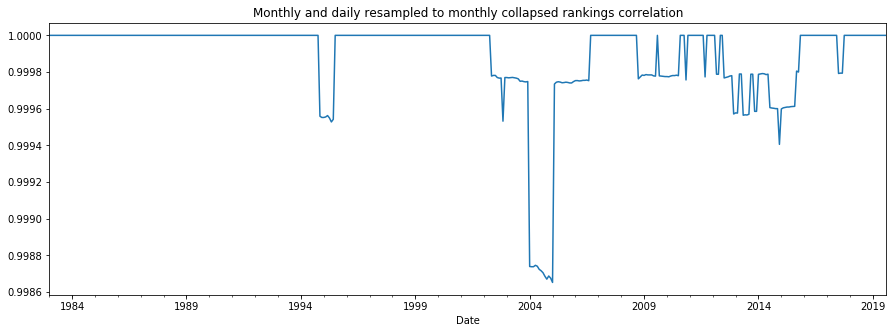

In [47]:
### TESTER
df_comparision = ser_ranking_monthly.to_frame().join(ser_ranking, how = 'left')
df_comparision.columns = ['Monthly', 'Daily']
print(df_comparision.describe())
print('Different revisions count:', df_comparision[df_comparision['Monthly'] != df_comparision['Daily']].count()[0])
print('Differences abs sum:', (df_comparision['Monthly'] - df_comparision['Daily']).abs().sum())
ser_correlation = df_comparision.groupby('Date').apply(lambda iter_group: iter_group['Monthly'].corr(iter_group['Daily']))
ser_correlation.dropna().plot(figsize = (15, 5), title = 'Monthly and daily resampled to monthly collapsed rankings correlation')
plt.show()